# FOTS: Fast Oriented Text Spotting with a Unified Network
[https://arxiv.org/pdf/1801.01671v2.pdf]

# ROIRotate Implementation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

- ** Note :- ** For using math expression in IPython notebook (as used here) refer to below :-
[https://en.wikibooks.org/wiki/LaTeX/Mathematics#Multiplication_of_two_numbers]

### Test image
- The test image is created using powerpoint
- Text region is created and rotated by 30 degrees anticlockwise
- Image size (w,h) = (600, 394)
- The reference point inside the bounding box $(x,y)$ is given as 
$$pref = (275, 139)$$
- The points perpendicularly to the top, left, bottom, right of the reference point on the bounding box are given as
$$pt = (223, 52)$$
$$pl = (112, 233)$$
$$pb = (292, 168)$$
$$pr = (334, 106)$$
- These points are highlighted in image on the blue lines inside the bounding box.
- The coordinate system is such that :-
    - Along x-axis, x increases from left to right.
    - Along y-axis, y increases from top to bottom.
    - Standard axis system used in computer vision libs (opencv, matplotlib etc.)

In [2]:
img_path = './Test_Image.jpg'
img=mpimg.imread(img_path)

In [3]:
img.shape

(394, 600, 3)

In [4]:
pref = (275, 139)
pt = (223, 52)
pl = (112, 233)
pb = (292, 168)
pr = (334, 106)

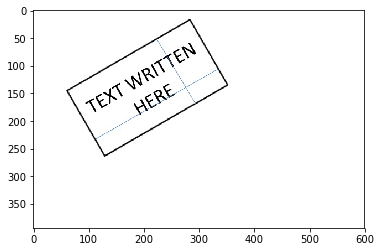

In [5]:
plt.imshow(img)

### Function to calculate distance between two points
- a, b are points in $(x,y)$ axis

In [6]:
def dist(a, b):
    return np.sqrt((a[0]-b[0])*(a[0]-b[0]) + (a[1]-b[1])*(a[1]-b[1]))

# Affine Transformations :- 

- The $pref=(xref,yref)$ point is the point inside the text region.
- Its distances from the top, left, bottom, right sides of the bounding box is given by variables $(t,l,b,r)$
- The angle from the horizontal of the bounding box is given by $\theta$
- **Note :-** There is some difference in equations in implementation and the one given in paper regarding $\theta$
- In the implementation, we take clockwise angle as +ve and anticlockwise as -ve.
- This implies, for the image in above example, $\theta$ = -30 degree ($\frac{-\pi}{6}$)
- While rotating, we have to rotate in opposite direction of theta so we do a rotation with ($-\theta$)
- Therefore affine transformation is carried out as follows :-

### Translation
- The top-left point of bounding box is shifted to origin.
- Coordinates of top-left point = $ (xtop, ytop) = (xref-(lcos\theta - tsin\theta), yref-(lsin\theta + tcos\theta) )$
    - Draw on paper and verify, apply trignometry
    - Consider that $\theta$ is +ve when clockwise else -ve
- Therefore transformation to shift to origin = $ (-xtop, -ytop) = ((lcos\theta - tsin\theta)-xref, (lsin\theta + tcos\theta)-yref )$
- This implies $(tx,ty) = ((lcos\theta - tsin\theta)-xref, (lsin\theta + tcos\theta)-yref )$
- Translation matrix = $$\left[ \begin{matrix} 
                                   1 & 0 & tx \\
                                   0 & 1 & ty \\
                                   0 & 0 & 1
                                 \end{matrix} \right]$$
                                 
### Rotation
- Now rotation is performed to align the bounding box to horizontal-vertical axis
- Rotation is carried out in the reverse direction of $\theta$
- That is, if $\theta$ is -ve we do a clockwise rotation and if $\theta$ is +ve we do anti-clockwise rotation.
- Clockwise rotation in our coordinate system (i.e. x increases to left to right and y increases top to bottom) is given by rotation matrix = $$\left[ \begin{matrix} 
                                   cos(\theta) & -sin(\theta) & 0 \\
                                   sin(\theta) & cos(\theta) & 0 \\
                                   0 & 0 & 1
                                 \end{matrix} \right]$$
- But if we are rotating clockwise, this means that bounding box angle $\theta$ must be -ve (anticlockwise).
- So, in effect we are rotating by $-\theta$
- Therefore rotation matrix = $$\left[ \begin{matrix} 
                                   cos(-\theta) & -sin(-\theta) & 0 \\
                                   sin(-\theta) & cos(-\theta) & 0 \\
                                   0 & 0 & 1
                                 \end{matrix} \right]$$                                 

### Scaling
- Finally scaling is done to bring the bounding box to the desired size.
- The height of the target bounding box (ht) is fixed. (In the paper, $ht = 8$)
- The width of the target bounding box (wt) is scaled maintaining the aspect ratio.
- Scaling factor s is given as :- $$s = \frac{ht}{t+b}$$
- This implies :- $$wt = s * (l+r)$$
- Scaling matrix = $$\left[ \begin{matrix} 
                                   s & 0 & 0 \\
                                   0 & s & 0 \\
                                   0 & 0 & 1
                                 \end{matrix} \right]$$
                                 
                                 
### Complete transformation
- Therefore the complete transformation from the source coordinate system $(xs,ys)$ to new coordinate system $(xt,yt)$ is given as $$ M = scaling * rotation * translation $$
- $$ M = \left[ \begin{matrix} 
                   s & 0 & 0 \\
                   0 & s & 0 \\
                   0 & 0 & 1
                 \end{matrix} \right] 
          \left[ \begin{matrix} 
                   cos(-\theta) & -sin(-\theta) & 0 \\
                   sin(-\theta) & cos(-\theta) & 0 \\
                   0 & 0 & 1
                 \end{matrix} \right] 
          \left[ \begin{matrix} 
                   1 & 0 & tx \\
                   0 & 1 & ty \\
                   0 & 0 & 1
                 \end{matrix} \right]$$

In [7]:
t = dist(pref, pt)
l = dist(pref, pl)
b = dist(pref, pb)
r = dist(pref, pr)
theta = -np.pi/6

In [8]:
# For visualization purpose setting ht to 96 (instead of 8 as in paper).
ht = 96.0
s = ht/(t+b)
wt = s*(l+r)

In [9]:
print (ht, wt)
print (t, l, b, r)
print (s)
print (np.sin(theta))

96.0 181.915277724
101.355808911 188.162164103 33.6154726279 67.6017751246
0.711262417497
-0.5


### Function to return the transformation matrix
- Given a reference point inside bounding box $(xref,yref)$ and distances from top, left, bottom, right edges $(t,l,b,r)$ and angle $\theta$.
- Returns the transformation matrix $M$ needed to perform affine transformation for converting coordinates from source to target.

In [10]:
def getTransformMatrix(x, y, t, l, b, r, theta):
    s = ht/(t+b)
    tx = (l*np.cos(theta)) - (t*np.sin(theta)) - x
    ty = (l*np.sin(theta)) + (t*np.cos(theta)) - y
    translate = np.array([[1, 0, tx], [0, 1, ty], [0, 0, 1]], dtype=np.float32)
    scale = np.array([[s, 0, 0], [0, s, 0], [0, 0, 1]], dtype=np.float32)
    rotate = np.array([[np.cos(-theta), -np.sin(-theta), 0], [np.sin(-theta), np.cos(-theta), 0], [0, 0, 1]], dtype=np.float32)
    M = np.matmul(scale, rotate)
    M = np.matmul(M, translate)
    return M

### Get the transformation matrix for our example image

In [11]:
M = getTransformMatrix(pref[0], pref[1], t, l, b, r, theta)
M_inv = np.linalg.inv(M)

In [12]:
print (M)
print (M_inv)

[[   0.61597133   -0.3556312    13.87329865]
 [   0.3556312     0.61597133 -111.32802582]
 [   0.            0.            1.        ]]
[[   1.21758914    0.70297539   61.36888504]
 [  -0.70297539    1.21758914  145.30438232]
 [   0.            0.            1.        ]]


### Performing inverse transformation
- Inverse transformation is used to find the source pixel for every pixel in target image.
- Target image size $(w,h) = (wt,ht)$ [Therefore array dimensions = $(ht,wt)$]
- for every pixel in target image $(x^t, y^t, 1)$, source pixel $(x^s, y^s, 1)$ is given as :-
$$ \left[ \begin{matrix} x^s \\ y^s \\ 1 \end{matrix} \right] = M^{-1} \left[ \begin{matrix} x^t \\ y^t \\ 1 \end{matrix} \right]$$

In [13]:
img_out = np.zeros((np.floor(ht), np.floor(wt), 3))

for i in range(int(np.floor(wt))):
    for j in range(int(np.floor(ht))):
        s_vec = np.matmul(M_inv, np.array([i, j, 1], dtype=np.float32))
        img_out[j, i, :] = img[int(s_vec[1]), int(s_vec[0]), :]

C:\Users\Honey\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


### Plotting the transformed image

(96, 181, 3)


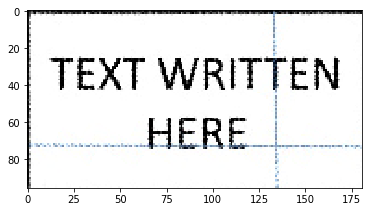

In [14]:
print(img_out.shape)
plt.imshow(img_out.astype('uint8'))